# AOS_PS1_ROTANG_inspect


Simulate a high-latitude field introducing 30 degree rotation

    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03  / lsst-devl01 
    
    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib
    setup -k -r /project/scichris/aos/phosim_utils/
    
    
    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ps1_phosim/test_rotang/stars_comCam_PS1_high_focal_rotskypos_30.inst -i comcam -e 1 -c /project/scichris/aos/ps1_phosim/noBkgnd.cmd -p 24 -w /project/scichris/aos/ps1_phosim/test_rotang/rotskypos -s R22_S01 -o /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/raw > /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/starPhoSim.log 2>&1

## 1) repackage with phosim_utils `master`

Repackage on phosim_utils `master`, where 


    ROTANG = 90 - PHOSIM_ROTANG 

    phosim_repackager.py /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/raw     --out_dir /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/repackaged2 --inst comcam

Ingest and run the ISR ...

    ./runIsr2.sh

    ingest INFO: Successfully extracted metadata from 1 file with 0 failures
    ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
    ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
    ingest INFO: Ingested 1 distinct Butler dataset
    defineVisits INFO: Preprocessing data IDs.
    defineVisits INFO: Registering visit_system 1: by-group-metadata.
    defineVisits INFO: Grouping 1 exposure(s) into visits.
    defineVisits INFO: Computing regions and other metadata for 1 visit(s).
    ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 1 quanta for 1 tasks, graph ID: '1621448295.036854-9592'
    conda.common.io INFO: overtaking stderr and stdout
    conda.common.io INFO: stderr and stdout yielding back
    isr INFO: Converting exposure to floating point values.
    isr INFO: Assembling CCD from amplifiers.
    isr INFO: Widening saturation trails.
    isr INFO: Applying gain correction instead of flat.
    isr WARN: No rough magnitude zero point set for filter FilterLabel(band="r", physical="r_03").
    isr INFO: Setting rough magnitude zero point: 28.000000
    ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTComCam', detector: 1, exposure: 4021123106002, ...} took 5.480 seconds
    ctrl.mpexec.mpGraphExecutor INFO: Executed 1 quanta successfully, 0 failed and 0 remain out of total 1 quanta.

In [2]:
import numpy as np
import os
import pandas as pd
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

%matplotlib inline

def plot_postIsr(repo_dir='/project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA2/',title='master'):

    instrument = 'LSSTComCam'
    inst_file = '/project/scichris/aos/ps1_phosim/test_rotang/stars_comCam_PS1_high_focal_rotskypos_30.inst'
    detector = 'R22_S01'

    print(f'Using {repo_dir}')
    butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                     f'{instrument}/calib','run1',
                                                     f'{instrument}/calib/unbounded']
                             )
    # this is just to get the exposure  number
    # so that we don't have  to guess...
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(
                        butler.registry.queryDatasets(
                            datasetType='postISRCCD', 
                            collections=['run1'],
                            dataId=dataId0  )
                        )
                   )
    exp_num = dataset.dataId["exposure"]


    exposure = butler.get('postISRCCD', detector=detector, instrument=instrument,
              exposure=exp_num,collections=['run1'])



    # read in the input instance catalog 
    cat = np.genfromtxt(inst_file, skip_header=16)

    cat_df = pd.DataFrame(cat[:, 1:5], columns=['id', 'ra', 'dec', 'g'])

    #########################
    # Use the original WCS 
    #########################

    # get the wcs 
    wcs = exposure.getWcs()

    # calculate the position given the x,y 
    x,y = wcs.skyToPixelArray(cat_df['ra'], cat_df['dec'],degrees=True)    


    # plot the WCS-inferred stellar position on top of the data 
    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)

    fig = plt.figure(figsize=(10,10))
    plt.imshow(data, vmin=vmin,vmax=vmax,cmap='Greys')
    plt.scatter(x,y,  facecolors='none', edgecolors='r', marker='o',s=50, )
    plt.xlim(0, 4000)
    plt.ylim(0, 4000)
    plt.title(f"lsstComCam {exposure.getDetector().getName()} {title} ")
    plt.xlabel('x [px]')
    plt.ylabel('y [px]')



Using /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA2/


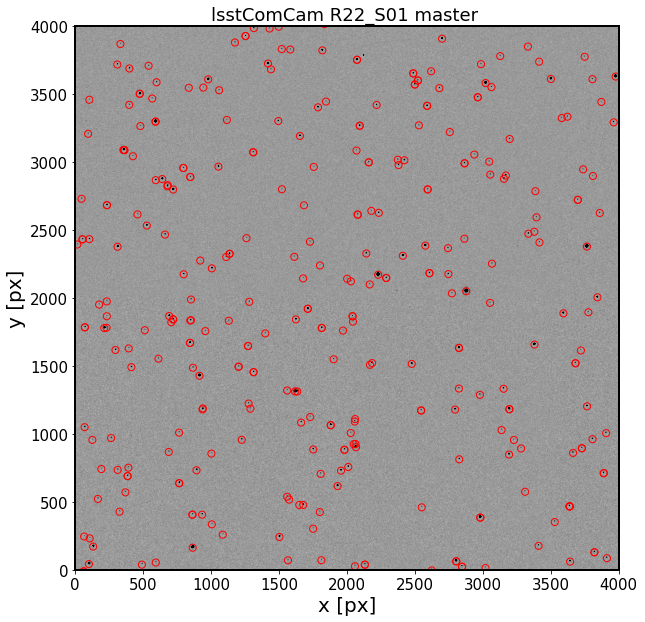

In [3]:
plot_postIsr(repo_dir='/project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA2/',title='master')

Thus correct WCS is attached to the exposure

## 2) Repackage with `phosim_utils` on `tickets/DM-30128` (Tiago's branch)

Repackage on `phosim_utils` tickets/DM-30128, where

    ROTANG = 90- PHOSIM_ROTANG (by default)
    phosim_repackager.py /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/raw     --out_dir /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/repackaged3 --inst comcam


    Ingest and run the ISR ...
    
    ./runIsr3.sh
    
    ingest INFO: Successfully extracted metadata from 1 file with 0 failures
ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
ingest INFO: Ingested 1 distinct Butler dataset
defineVisits INFO: Preprocessing data IDs.
defineVisits INFO: Registering visit_system 1: by-group-metadata.
defineVisits INFO: Grouping 1 exposure(s) into visits.
defineVisits INFO: Computing regions and other metadata for 1 visit(s).
ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 1 quanta for 1 tasks, graph ID: '1621463516.076867-484099'
conda.common.io INFO: overtaking stderr and stdout
conda.common.io INFO: stderr and stdout yielding back
isr INFO: Converting exposure to floating point values.
isr INFO: Assembling CCD from amplifiers.
isr INFO: Widening saturation trails.
isr INFO: Applying gain correction instead of flat.
isr WARN: No rough magnitude zero point set for filter FilterLabel(band="r", physical="r_03").
isr INFO: Setting rough magnitude zero point: 28.000000
ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTComCam', detector: 1, exposure: 4021123106002, ...} took 4.458 seconds
ctrl.mpexec.mpGraphExecutor INFO: Executed 1 quanta successfully, 0 failed and 0 remain out of total 1 quanta.

Using /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA3/


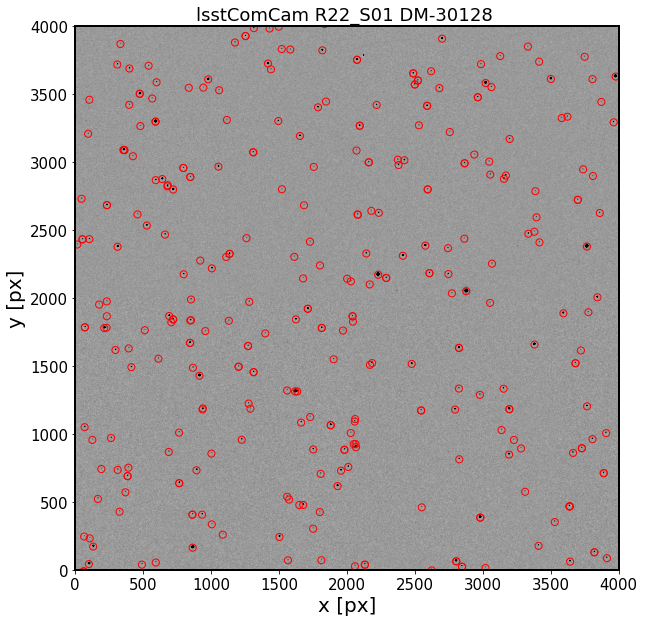

In [20]:
plot_postIsr(repo_dir='/project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA3/',title='DM-30128')

The attached WCS is now correct. Check the header translation:

    astrometadata -p lsst.obs.lsst.translators translate repackaged2/   # master 
    
    Analyzing repackaged2/CC_H_20211231_006002_R22_S01.fits...
    instrument: LSSTComCam
    telescope: Simonyi Survey Telescope
    datetime_begin: 2021-12-31T23:59:59.500
    altaz_begin: None
    boresight_airmass: 1.24813143788881
    boresight_rotation_angle: 60.0 deg
    boresight_rotation_coord: sky
    dark_time: 1.0 s
    datetime_end: 2022-01-01T00:00:00.500
    detector_exposure_id: 4021123106002001
    detector_group: R22
    detector_name: S01
    detector_num: 1
    detector_serial: ITL-3800C-251
    detector_unique_name: R22_S01
    exposure_group: 4021123106002
    exposure_id: 4021123106002
    exposure_time: 1.0 s
    location: (1818938.94323602, -5208470.950938, -3195172.08426757) m
    object: UNKNOWN
    observation_counter: 6002
    observation_id: 9006002
    observation_reason: phosim
    observation_type: science
    observing_day: 20211231
    physical_filter: r_03
    pressure: None
    relative_humidity: None
    science_program: 9006002
    temperature: None
    tracking_radec: <SkyCoord (ICRS): (ra, dec) in deg
        (197.464413, 24.335542)>
    visit_id: 4021123106002



     astrometadata -p lsst.obs.lsst.translators translate repackaged3/   # tickets/DM-30128 
     
     Analyzing repackaged3/CC_H_20211231_006002_R22_S01.fits...
    instrument: LSSTComCam
    telescope: Simonyi Survey Telescope
    datetime_begin: 2021-12-31T23:59:59.500
    altaz_begin: None
    boresight_airmass: 1.24813143788881
    boresight_rotation_angle: 60.0 deg
    boresight_rotation_coord: sky
    dark_time: 1.0 s
    datetime_end: 2022-01-01T00:00:00.500
    detector_exposure_id: 4021123106002001
    detector_group: R22
    detector_name: S01
    detector_num: 1
    detector_serial: ITL-3800C-251
    detector_unique_name: R22_S01
    exposure_group: 4021123106002
    exposure_id: 4021123106002
    exposure_time: 1.0 s
    location: (1818938.94323602, -5208470.950938, -3195172.08426757) m
    object: UNKNOWN
    observation_counter: 6002
    observation_id: 9006002
    observation_reason: phosim
    observation_type: science
    observing_day: 20211231
    physical_filter: r_03
    pressure: None
    relative_humidity: None
    science_program: 9006002
    temperature: None
    tracking_radec: <SkyCoord (ICRS): (ra, dec) in deg
        (197.464413, 24.335542)>
    visit_id: 4021123106002

## Test the case for `ts_phosim` of using `--no-derotate` 

    phosim_repackager.py /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/raw     --out_dir /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/repackaged4 --inst comcam --no-derotate
    
    
     Ingest and run the ISR ...
    
    ./runIsr4.sh
    
    
    ingest INFO: Successfully extracted metadata from 1 file with 0 failures
    ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
    ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
    ingest INFO: Ingested 1 distinct Butler dataset
    defineVisits INFO: Preprocessing data IDs.
    defineVisits INFO: Registering visit_system 1: by-group-metadata.
    defineVisits INFO: Grouping 1 exposure(s) into visits.
    defineVisits INFO: Computing regions and other metadata for 1 visit(s).
    ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 1 quanta for 1 tasks, graph ID: '1621463796.543594-486638'
    conda.common.io INFO: overtaking stderr and stdout
    conda.common.io INFO: stderr and stdout yielding back
    isr INFO: Converting exposure to floating point values.
    isr INFO: Assembling CCD from amplifiers.
    isr INFO: Widening saturation trails.
    isr INFO: Applying gain correction instead of flat.
    isr WARN: No rough magnitude zero point set for filter FilterLabel(band="r", physical="r_03").
    isr INFO: Setting rough magnitude zero point: 28.000000
    ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTComCam', detector: 1, exposure: 4021123106002, ...} took 4.226 seconds
    ctrl.mpexec.mpGraphExecutor INFO: Executed 1 quanta successfully, 0 failed and 0 remain out of total 1 quanta.
    

Using /project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA4/


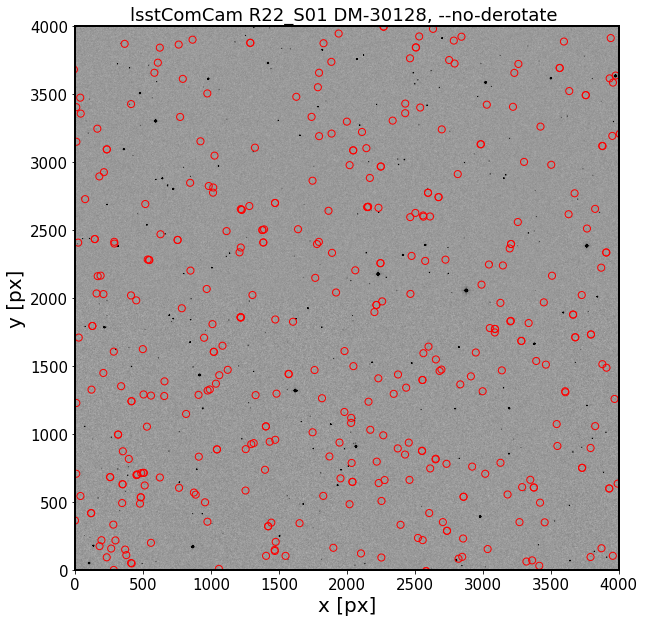

In [22]:
plot_postIsr(repo_dir='/project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA4/',title='DM-30128, --no-derotate')

Try plotting overlay with astropy... 

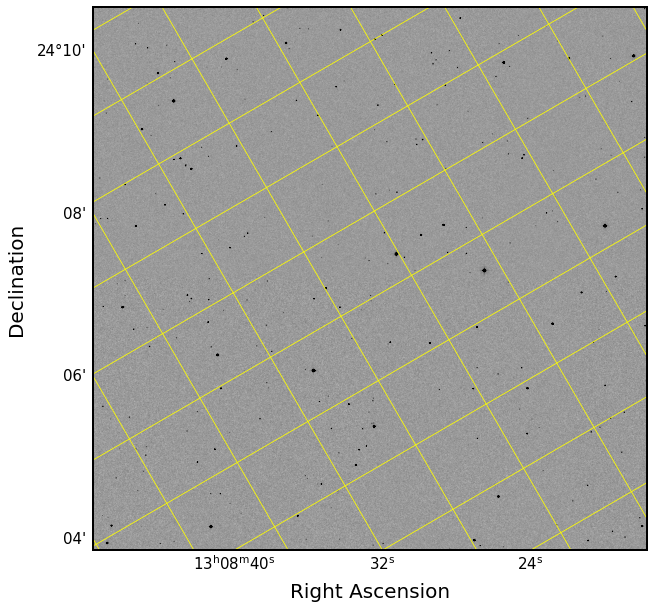

In [23]:
import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import os
from astropy.wcs import WCS
from astropy.io import fits
from astropy import units as u
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

# path to a post ISR image 
file_path = '/project/scichris/aos/ps1_phosim/test_rotang/rotskypos/DATA3/\
run1/postISRCCD/20211231/CC_H_20211231_006002/\
postISRCCD_LSSTComCam_r_03_CC_H_20211231_006002_R22_S01_run1.fits'

# make a WCS object 
hdul = fits.open(file_path)
wcs1 = WCS(hdul[1].header)


data = hdul[1].data
vmin, vmax = zscale.get_limits(data)


# plot the data and the WCS overlay 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=wcs1)
ax.imshow(data,  origin='lower', vmin=vmin, vmax=vmax,cmap='Greys',)
ax.grid(color='yellow', ls='solid')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

ra = ax.coords['ra']
dec = ax.coords['dec']

ra.set_ticks(spacing=2 * u.arcmin, color='white')
dec.set_ticks(spacing=2 * u.arcmin, color='white')

but if `rotskypos` is 0, it doesn't workk.... 